# Women's World Cup 2023 - Prediction Competition

## Introduction

In this notebook we'll show you how to build a submission for the competition using a simple model. The notebook assumes you are running Python 3.8 or higher. We'll start by loading some libraries. Make sure you have these installed:

In [1]:
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import poisson

## Building a Submission

Recall that a submission consists of predictions for all group stage matches and every possible pairwise combination of teams for the knockout stage. First we define the set of teams participating in the tournament and the group that they are assigned to:

In [2]:
team_to_group = {
    'New Zealand': 'A',
    'Norway': 'A',
    'Philippines': 'A',
    'Switzerland': 'A',
    'Australia': 'B',
    'Republic of Ireland': 'B',
    'Nigeria': 'B',
    'Canada': 'B',
    'Spain': 'C',
    'Costa Rica': 'C',
    'Zambia': 'C',
    'Japan': 'C',
    'England': 'D',
    'Haiti': 'D',
    'Denmark': 'D',
    'China PR': 'D',
    'USA': 'E',
    'Vietnam': 'E',
    'Netherlands': 'E',
    'Portugal': 'E',
    'France': 'F',
    'Jamaica': 'F',
    'Brazil': 'F',
    'Panama': 'F',
    'Sweden': 'G',
    'South Africa': 'G',
    'Italy': 'G',
    'Argentina': 'G',
    'Germany': 'H',
    'Morocco': 'H',
    'Colombia': 'H',
    'Korea Republic': 'H'
}

We'll define two functions:

1. Given two teams that are playing in a group stage match, produce three probabilities: the probability the first team wins, the probability the second team wins, and the probability of a draw
2. Given two teams that are playing in a knockout stage match, produce two probabilities: the probability that the first team progresses to the next stage (i.e. they win either in regular team or at the end of extra time or in the penalty shootout), and the probability that the second team progresses to the next stage

For now, both functions will simply assign a probability of 1 to the first team and 0 to the other outcomes

In [3]:
def p_group_stage(team1: str, team2: str) -> list[float]:
    return [1.0, 0.0, 0.0]


def p_knockout_stage(team1: str, team2: str) -> list[float]:
    return [1.0, 0.0]

Now we will write some code to produce an entry given these two functions:

In [4]:
submission_group = pd.DataFrame(
    {
        'team1': team1,
        'team2': team2,
        'group': team_to_group[team1],
        'p_team1_win': (p := p_group_stage(team1, team2))[0],
        'p_team2_win': p[1],
        'p_draw': p[2],
    }
    for team1, team2 in itertools.combinations(team_to_group.keys(), 2)
    if team_to_group[team1] == team_to_group[team2]
)

submission_knockout = pd.DataFrame(
    {
        'team1': team1,
        'team2': team2,
        'group': 'Knockout',
        'p_team1_win': (p := p_knockout_stage(team1, team2))[0],
        'p_team2_win': p[1],
        'p_draw': None,
    }
    for team1, team2 in itertools.combinations(team_to_group.keys(), 2)
)

submission = pd.concat((submission_group, submission_knockout))

submission

,team1,team2,group,p_team1_win,p_team2_win,p_draw
0,New Zealand,Norway,A,1.0,0.0,0.0
1,New Zealand,Philippines,A,1.0,0.0,0.0
2,New Zealand,Switzerland,A,1.0,0.0,0.0
3,Norway,Philippines,A,1.0,0.0,0.0
4,Norway,Switzerland,A,1.0,0.0,0.0
...,...,...,...,...,...,...
491,Germany,Colombia,Knockout,1.0,0.0,None
492,Germany,Korea Republic,Knockout,1.0,0.0,None
493,Morocco,Colombia,Knockout,1.0,0.0,None
494,Morocco,Korea Republic,Knockout,1.0,0.0,None


Looking good! The submission can be saved to CSV ready to be submitted:

In [5]:
submission.to_csv("submission.csv", index=False)

## Using a Model

### Introduction

Obviously the "model" we have used - predicting the first team is always guaranteed to win the match/progress to the next knockout stage - is unlikely to be competitive. However, the structure laid out above means that generating a more sophisticated entry is as simple as rewriting the function `p_group_stage` and `p_knockout_stage`

A canonical starting point for the modelling of football matches is to assume that the goals scored by each team are independently Poisson distributed. The mean parameter for each Poisson distribution is broken down into attack and defence parameters for each team plus a parameter for home advantage that models the often significant benefit a team receives when playing at their home stadium. For more details about such a model see

> Dixon, M.J. and Coles, S.G. (1997), Modelling Association Football Scores and Inefficiencies in the Football Betting Market. Journal of the Royal Statistical Society: Series C (Applied Statistics), 46: 265-280. https://doi.org/10.1111/1467-9876.00065

Which is open access and a seminal contribution to this field

### Data

We'll illustrate fitting this model to data compiled by [Mart Jürisoo](https://martj42.github.io/) who maintains an easy to consume CSV file of Women's international football results:

In [6]:
url = "https://raw.githubusercontent.com/martj42/womens-international-results/ae285e00fa19c7edc4b986a01d135ae6f6545fb8/results.csv"
data = pd.read_csv(url)

data

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1969-11-01,Italy,France,1,0,Euro,Novara,Italy,False
1,1969-11-01,Denmark,England,4,3,Euro,Aosta,Italy,True
2,1969-11-02,England,France,2,0,Euro,Turin,Italy,True
3,1969-11-02,Italy,Denmark,3,1,Euro,Turin,Italy,False
4,1970-07-06,England,West Germany,5,1,World Cup,Genova,Italy,True
...,...,...,...,...,...,...,...,...,...
5590,2023-02-22,United States,Brazil,2,1,SheBelieves Cup,Frisco,United States,False
5591,2023-02-23,Paraguay,Panama,0,1,FIFA World Cup qualification,Hamilton,New Zealand,True
5592,2023-02-23,Taiwan,Papua New Guinea,5,0,FIFA World Cup qualification,Auckland,New Zealand,True
5593,2023-02-23,New Zealand,Argentina,0,1,FIFA World Cup qualification,Auckland,New Zealand,False


The data goes back to 1969 and covers a wide range of tournaments:

In [7]:
data.tournament.value_counts()

UEFA Euro qualification                      1445
Algarve Cup                                   551
FIFA World Cup qualification                  421
FIFA World Cup                                284
AFC Championship                              268
Cyprus Cup                                    264
African Championship qualification            226
UEFA Euro                                     184
African Championship                          173
Copa América                                  156
CONCACAF Gold Cup qualification               143
AFC Asian Cup qualification                   141
Olympic Games                                 130
CONCACAF Gold Cup                             126
Friendly                                      112
AFC Asian Cup                                 111
Four Nations Tournament                       106
OFC Championship                               78
International Tournament                       74
Turkish Women's Cup                            64


With this choice of model, there is a trade-off to be made between using data that is recent enough to be relevant and ensuring a large enough sample size. More sophisticated methods such as exponentionally weighting observations have been proposed in the literature but are outside the scope of this tutorial. Instead, we will simply use all matches from the last Women's World Cup - in 2019 - onwards:

In [8]:
data = data.query("date >= '2019-06-07'")

### Fitting the Model

Fitting the described model boils down to fitting a Poisson GLM with a log link function. The independent variables are team name, opponent name and whether the team is the home team, the away team or neither, which is the case for matches played at a neutral venue

As it stands, each row in the data consists of a match but we need to transform this so each row is a team playing in a given match. In other words, each match contributes two observations: one for each team:

In [9]:
home_data = data[["home_team", "away_team", "home_score", "neutral"]].rename(
    columns={"home_team": "team", "away_team": "opponent", "home_score": "goals_scored"}
).assign(
    location=lambda x: np.where(x.neutral, "neutral", "home")
).drop(columns=["neutral"])
home_data

,team,opponent,goals_scored,location
4644,France,South Korea,4,home
4645,Norway,Nigeria,3,neutral
4646,Germany,China PR,1,neutral
4647,Spain,South Africa,3,neutral
4648,Australia,Italy,1,neutral
...,...,...,...,...
5590,United States,Brazil,2,home
5591,Paraguay,Panama,0,neutral
5592,Taiwan,Papua New Guinea,5,neutral
5593,New Zealand,Argentina,0,home


In [10]:
away_data = data[["away_team", "home_team", "away_score", "neutral"]].rename(
    columns={"away_team": "team", "home_team": "opponent", "away_score": "goals_scored"}
).assign(
    location=lambda x: np.where(x.neutral, "neutral", "away")
).drop(columns=["neutral"])
away_data

,team,opponent,goals_scored,location
4644,South Korea,France,0,away
4645,Nigeria,Norway,0,neutral
4646,China PR,Germany,0,neutral
4647,South Africa,Spain,1,neutral
4648,Italy,Australia,2,neutral
...,...,...,...,...
5590,Brazil,United States,1,away
5591,Panama,Paraguay,1,neutral
5592,Papua New Guinea,Taiwan,0,neutral
5593,Argentina,New Zealand,1,away


For some teams, there are very few observations and, in the worse cases, they only played in a single match over this time period:

<AxesSubplot:ylabel='Frequency'>

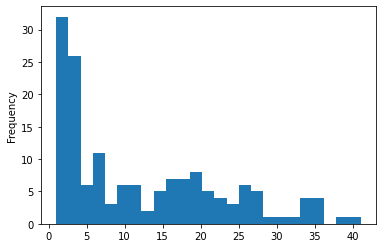

In [11]:
fit_data = pd.concat((home_data, away_data))
fit_data.team.value_counts().plot.hist(bins=25)

To avoid numerical issues when fitting the model, we will restrict to teams that have played at least 5 matches over the time period:

In [12]:
teams_to_remove = fit_data.team.value_counts().reset_index().query("team < 5")["index"]
teams_to_remove

97                        Ghana
98            Equatorial Guinea
99                         Peru
100                       Kenya
101                       Gabon
102                        Mali
103                 Ivory Coast
104                     Ecuador
105                        Iran
106                     Bolivia
107                    Zimbabwe
108                     Namibia
109                      Gambia
110               Guinea-Bissau
111                     Comoros
112                   Mauritius
113                      Tahiti
114         Trinidad and Tobago
115                Cook Islands
116                        Guam
117                    Pakistan
118        United Arab Emirates
119                     Algeria
120                       Tonga
121               New Caledonia
122                Saudi Arabia
123                 South Sudan
124                     Vanuatu
125    Central African Republic
126                    Djibouti
127                       Nepal
128     

In [13]:
fit_data = fit_data.query("team not in @teams_to_remove and opponent not in @teams_to_remove")

We can now fit the model using the `statsmodels` package:

In [14]:
model = smf.glm(
    "goals_scored ~  C(location) + C(team) + C(opponent) - 1",
    data=fit_data,
    family=sm.families.Poisson()
)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           goals_scored   No. Observations:                 1658
Model:                            GLM   Df Residuals:                     1463
Model Family:                 Poisson   Df Model:                          194
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2179.1
Date:                Sun, 09 Jul 2023   Deviance:                       1502.8
Time:                        17:42:58   Pearson chi2:                 1.41e+03
No. Iterations:                    22   Pseudo R-squ. (CS):             0.8355
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
C(location)[away]                         0.3146      0.268      1.173      0.241      -0.211       0.840
C(location)[home]                         0.5297      0.268      1.979      0.048       0.005       1.054
C(location)[neutral]                      0.4778      0.276      1.732      0.083      -0.063       1.019
C(team)[T.Argentina]                      0.9073      0.333      2.723      0.006       0.254       1.560
C(team)[T.Armenia]                       -1.4214      0.497     -2.858      0.004      -2.396      -0.447
C(team)[T.Australia]                      1.2353      0.312      3.960      0.000       0.624       1.847
C(team)[T.Austria]                        0.9375      0.264      3.548      0.000       0.420       1.455
C(team)[T.Azerbaijan]                    -0.9115      0.447     -2.041      0.041      -1.787      -0.036
C(team)[T.Belarus]                        0.0738      0.325      0.227      0.820      -0.563       0.710
C(team)[T.Belgium]                        1.2741      0.244      5.227      0.000       0.796       1.752
C(team)[T.Bosnia and Herzegovina]         0.1564      0.306      0.511      0.610      -0.444       0.757
C(team)[T.Botswana]                      -0.0498      0.568     -0.088      0.930      -1.164       1.064
C(team)[T.Brazil]                         1.2602      0.281      4.479      0.000       0.709       1.812
C(team)[T.Bulgaria]                      -0.9170      0.408     -2.247      0.025      -1.717      -0.117
C(team)[T.Burkina Faso]                  -0.8833      0.837     -1.056      0.291      -2.523       0.756
C(team)[T.Burundi]                        0.2867      0.675      0.425      0.671      -1.037       1.610
C(team)[T.Cameroon]                       0.0738      0.431      0.171      0.864      -0.771       0.919
C(team)[T.Canada]                         0.9391      0.321      2.928      0.003       0.311       1.568
C(team)[T.Chile]                          0.6137      0.330      1.861      0.063      -0.033       1.260
C(team)[T.China PR]                       1.0314      0.369      2.794      0.005       0.308       1.755
C(team)[T.Colombia]                       0.9692      0.357      2.712      0.007       0.269       1.670
C(team)[T.Costa Rica]                     0.4595      0.435      1.056      0.291      -0.394       1.313
C(team)[T.Croatia]                       -0.2452      0.322     -0.761      0.446      -0.877       0.386
C(team)[T.Cyprus]                        -1.7531      0.745     -2.355      0.019      -3.212      -0.294
C(team)[T.Czech Republic]                 0.8357      0.265      3.148      0.002       0.315       1.356
C(team)[T.Denmark]                        1.1603      0.259      4.482      0.000       0.653       1.668
C(team)[T

### Model Exploration

We can take a look at the model parameters to see if they make sense. First, we can look at the attacking strengths:

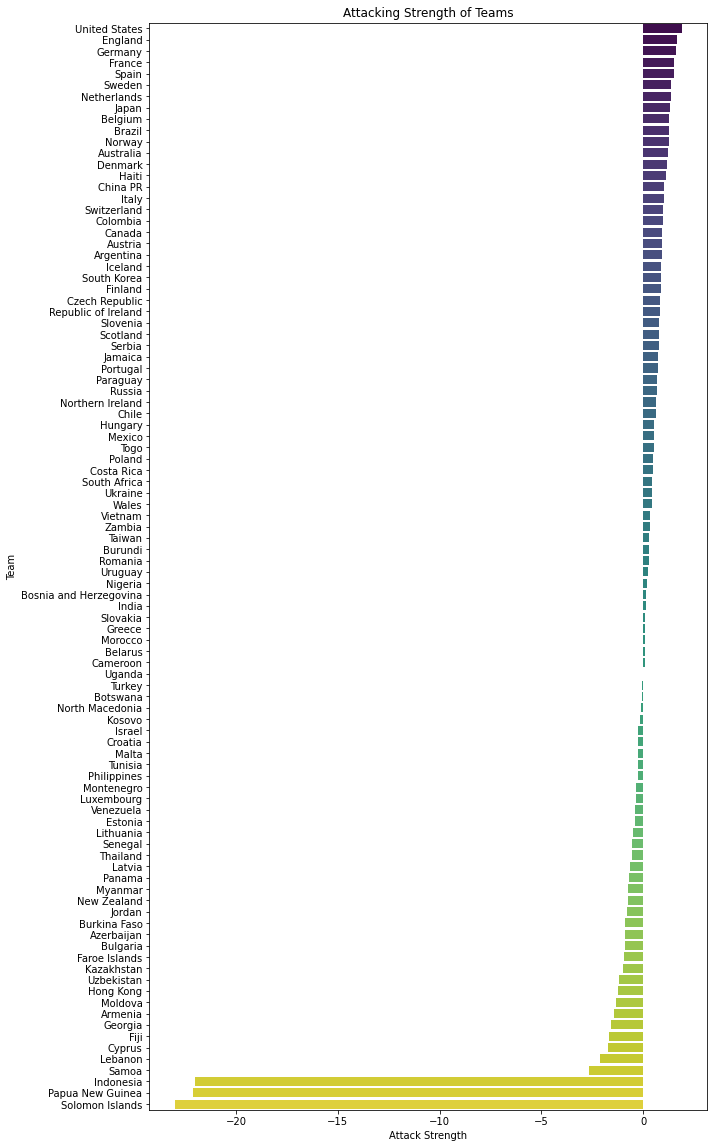

In [15]:
# Extract the coefficients from the fitted model
params = fit.params

# Filter the parameters to get only the attacking strengths
attack_strengths = params.filter(like='team')

# Convert the Series to a DataFrame and reset the index
attack_strengths = attack_strengths.reset_index()
attack_strengths.columns = ['team', 'attack_strength']

# Clean up the team names by removing the 'C(team)[T.' prefix and ']' suffix
attack_strengths['team'] = attack_strengths['team'].str.replace('C(team)[T.', '', regex=False)
attack_strengths['team'] = attack_strengths['team'].str.replace(']', '', regex=False)

# Sort the teams by attacking strength
attack_strengths = attack_strengths.sort_values('attack_strength', ascending=False)

# Create the bar chart
plt.figure(figsize=(10,20))
sns.barplot(x='attack_strength', y='team', data=attack_strengths, palette='viridis')
plt.title('Attacking Strength of Teams')
plt.xlabel('Attack Strength')
plt.ylabel('Team')
plt.show()

The two strongest teams in attack are the USA and England and these teams are the top two favourites to win the tournament. We can now repeat for the defending strengths:

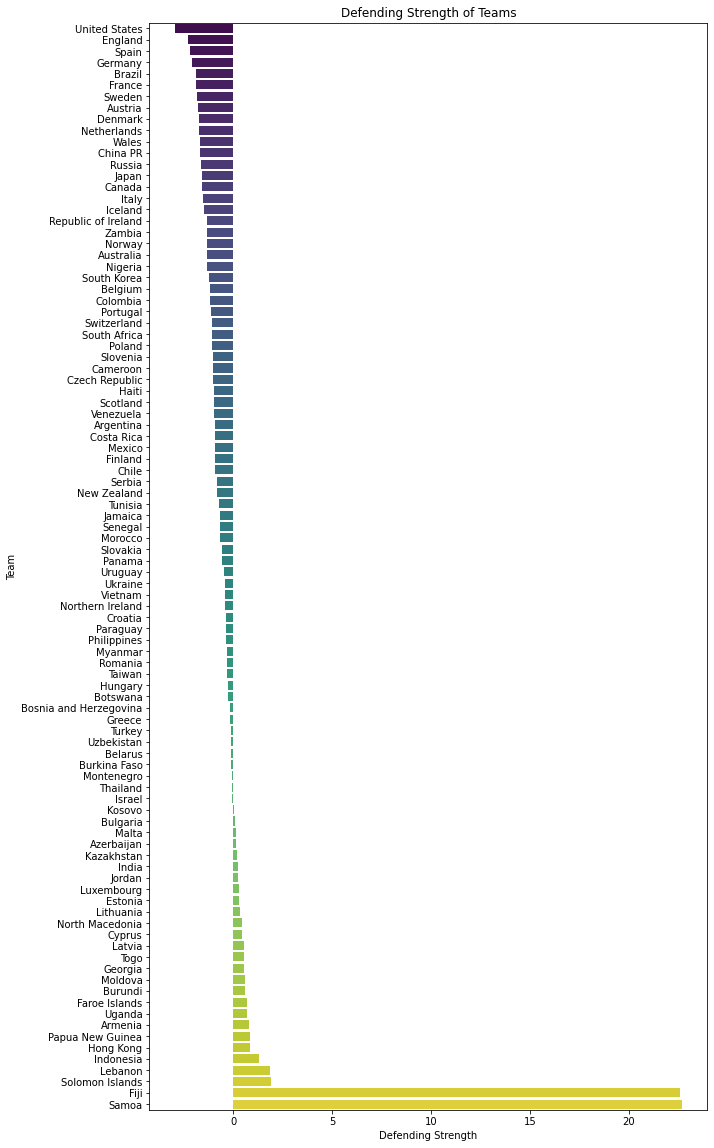

In [16]:
# Filter the parameters to get only the attacking strengths
defence_strengths = params.filter(like='opponent')

# Convert the Series to a DataFrame and reset the index
defence_strengths = defence_strengths.reset_index()
defence_strengths.columns = ['team', 'defence_strength']

# Clean up the team names by removing the 'C(team)[T.' prefix and ']' suffix
defence_strengths['team'] = defence_strengths['team'].str.replace('C(opponent)[T.', '', regex=False)
defence_strengths['team'] = defence_strengths['team'].str.replace(']', '', regex=False)

# Sort the teams by attacking strength
defence_strengths = defence_strengths.sort_values('defence_strength', ascending=True)

# Create the bar chart
plt.figure(figsize=(10,20))
sns.barplot(x='defence_strength', y='team', data=defence_strengths, palette='viridis')
plt.title('Defending Strength of Teams')
plt.xlabel('Defending Strength')
plt.ylabel('Team')
plt.show()

For defending, a lower strength is better as this parameter acts to decrease the expected goals of a team's opponents. Again, USA and England are the strongest teams at defending

### Building a New Submission

Now that we have a model fit, we are ready to rewrite the `p_group_stage` and `p_knockout_stage` functions and build a more sophisticated submission

In [17]:
submission_name_to_fit_name = {
    "USA": "United States",
    "Korea Republic": "South Korea"
}

def p_group_stage(team1: str, team2: str) -> list[float]:
    team1 = submission_name_to_fit_name.get(team1, team1)
    team2 = submission_name_to_fit_name.get(team2, team2)
    
    # Get the attack strengths
    team1_attack = fit.params[f'C(team)[T.{team1}]']
    team2_attack = fit.params[f'C(team)[T.{team2}]']
    
    # Get the defence strengths
    team1_defence = fit.params[f'C(opponent)[T.{team1}]']
    team2_defence = fit.params[f'C(opponent)[T.{team2}]']

    # Get the neutral home advantage parameter
    neutral_home_advantage = fit.params['C(location)[neutral]']

    # Calculate the expected number of goals for the home and away team
    expected_team1_goals = np.exp(team1_attack + team1_defence + neutral_home_advantage)
    expected_team2_goals = np.exp(team2_attack + team2_defence + neutral_home_advantage)

    # Calculate the maximum number of goals to consider in the Poisson distribution
    max_goals = 10

    # Calculate the probability of each possible outcome
    team1_win = 0
    team2_win = 0
    draw = 0
    for team1_goals in range(max_goals):
        for team2_goals in range(max_goals):
            # Calculate the probability of this outcome
            prob = poisson.pmf(team1_goals, expected_team1_goals) * poisson.pmf(team2_goals, expected_team2_goals)

            # Add the probability to the correct outcome
            if team1_goals > team2_goals:
                team1_win += prob
            elif team1_goals < team2_goals:
                team2_win += prob
            else:
                draw += prob

    return [team1_win, team2_win, draw]

def p_knockout_stage(team1: str, team2: str) -> list[float]:
    group_stage_probabilities = p_group_stage(team1, team2)
    team1_win = group_stage_probabilities[0] / (1.0 - group_stage_probabilities[2])
    team2_win = group_stage_probabilities[1] / (1.0 - group_stage_probabilities[2])
    return [team1_win, team2_win]

Some comments on how we've approached this:

1. We need to handle different naming conventions between our map of team name to group and the data used to fit the model
2. We've assumed that all teams are playing at a neutral venue. Australia and New Zealand are co-hosts so we could take this into account but it's a bit unclear how to correctly handle the case where they play each other
2. For the knockout stage, we just predict the match outcome allowing for a draw then rescale the probability that each team wins by removing the probability of the draw

Having redefined the two functions we can now run the same code for generating the submission:

In [18]:
submission_group = pd.DataFrame(
    {
        'team1': team1,
        'team2': team2,
        'group': team_to_group[team1],
        'p_team1_win': (p := p_group_stage(team1, team2))[0],
        'p_team2_win': p[1],
        'p_draw': p[2],
    }
    for team1, team2 in itertools.combinations(team_to_group.keys(), 2)
    if team_to_group[team1] == team_to_group[team2]
)

submission_knockout = pd.DataFrame(
    {
        'team1': team1,
        'team2': team2,
        'group': 'Knockout',
        'p_team1_win': (p := p_knockout_stage(team1, team2))[0],
        'p_team2_win': p[1],
        'p_draw': None,
    }
    for team1, team2 in itertools.combinations(team_to_group.keys(), 2)
)

submission = pd.concat((submission_group, submission_knockout))

submission

,team1,team2,group,p_team1_win,p_team2_win,p_draw
0,New Zealand,Norway,A,0.081831,0.667628,0.250537
1,New Zealand,Philippines,A,0.142408,0.458681,0.39891
2,New Zealand,Switzerland,A,0.085544,0.654283,0.260169
3,Norway,Philippines,A,0.526331,0.212232,0.261433
4,Norway,Switzerland,A,0.388996,0.365844,0.245153
...,...,...,...,...,...,...
491,Germany,Colombia,Knockout,0.390557,0.609441,None
492,Germany,Korea Republic,Knockout,0.455136,0.544864,None
493,Morocco,Colombia,Knockout,0.359323,0.640675,None
494,Morocco,Korea Republic,Knockout,0.422416,0.577583,None


## Possible Next Steps

The model presented here is a reasonable starting point but there is plenty of scope for improvement:

1. The Poisson assumption is known not to hold in practice. Alternatives such as a Weibull count model have been proposed in the literature
2. As discussed, we have ignored the question of home advantage for Australia and New Zealand
3. The method of rescaling probabilities for knockout matches may not reflect reality. Some teams might handle the pressure of extra time and penalty shootouts better than others in ways that aren't captured by their attack and defence parameters
4. Winning entries for previous editions of our prediction competition have made extensive use of bookmaker odds:
    1. Bookmaker odds are available for the opening round of matches. It would be very challenging to produce predictions for these matches better than those you can extract from the bookmaker odds. However, exactly how the odds are turned into probabilities is an area of potential competitive advantage
    2. As an alternative to fitting a model to match outcomes as we have done here, it is possible to fit the model to implied probabilities from bookmaker odds which contain much more information that the result alone